# Double-q learning
An example

In [37]:
import agents
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

In [38]:
%config InlineBackend.figure_format = "retina"

In [39]:
map_states = {
    "A": 0,
    "B": 1,
}

map_actions = {
    "left": 0,
    "right": 1,
}

In [243]:
n_arms_B = 50
rewards = np.random.normal(loc=-0.1, scale=1, size=n_arms_B)

In [248]:
@njit
def step(state, action):
    if state == 0:
        reward = 0
        if action == 1: # right
            new_state = -1 # terminal state
        if action == 0: # left
            new_state = 1

    if state == 1:
        new_state = -1 # terminal state
        np.random.normal(loc=-0.1, scale=1.0)
        # reward = rewards[action]

    return new_state, reward

@njit
def q_step(state, Q, epsilon, alpha, gamma):
    action = agents.choose_action(state, Q, epsilon)
    new_state, reward = step(state, action)
    q_new = Q[state][action] + alpha * (reward + gamma * Q[new_state].max() - Q[state][action])

    # if at terminal state, return to A
    if new_state == -1:
        new_state = 0
        
    return (new_state, action), q_new

In [270]:
Qv = (
    np.zeros(2,), # left, right actions
    np.zeros(n_arms_B,),
    np.zeros(1,) # terminal state
)

epsilon = 0.1
alpha = 0.1
gamma = 1.0

n_steps = 500

state = 0

n_steps_A = 0
n_episodes = 300
actions_in_A = np.zeros(n_episodes)

while n_steps_A != n_episodes:
    (state_new, action), Q_update = q_step(state, Qv, epsilon, alpha, gamma)

    if state == 0:
        actions_in_A[n_steps_A] = action
        n_steps_A += 1
    
    Qv[state][action] = Q_update
    
    state = state_new

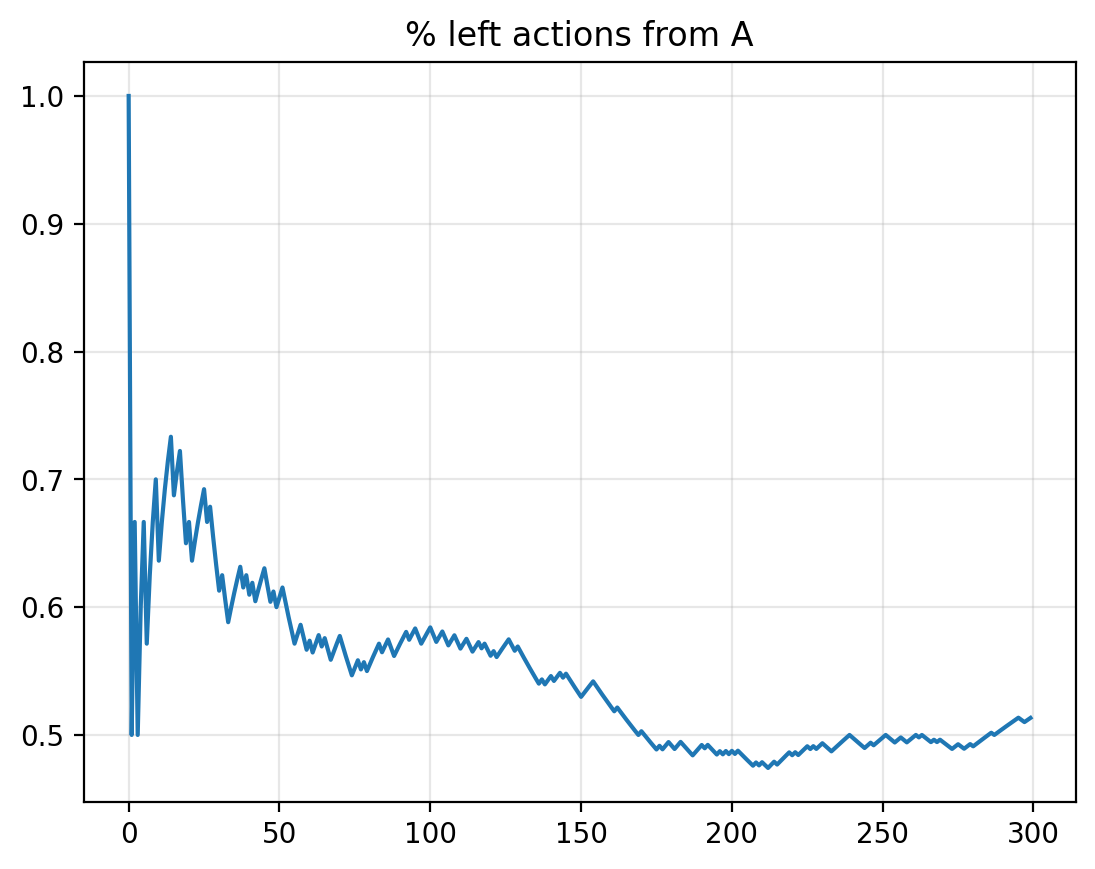

In [271]:
cumulative_episodes = np.ones_like(actions_in_A).cumsum()
plt.plot((1 - actions_in_A).cumsum() / cumulative_episodes)
plt.title("% left actions from A")
plt.grid(alpha=0.3)